In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Activation
from tensorflow.keras.optimizers import RMSprop, Adam

from matplotlib import pyplot as plt
import numpy as np

In [26]:
class solver(Sequential):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.loss_tracker = keras.metrics.Mean(name = 'loss')
    self.mse = tf.keras.losses.MeanSquaredError()

  @property
  def metrics(self):
    return [self.loss_tracker]

  def train_step(self, data):
    batch_size = tf.shape(data)[0]  # Obtener el tamaño del batch
    min = tf.cast(tf.reduce_min(data), tf.float32)  # Obtiene el valor mínimo de los datos de entrada
    max = tf.cast(tf.reduce_max(data), tf.float32)
    x = tf.random.uniform((batch_size, 1), minval = min, maxval = max)  # Tensor con datos aleatorios entre min y max

    with tf.GradientTape() as tape:
      with tf.GradientTape() as tape2:
        tape2.watch(x)                      # Seguimiento de x en tape2
        y_pred = self(x, training = True)   # Solución y predicha según los datos x
      dy = tape2.gradient(y_pred, x)        # Derivada de y_pred respecto a x

      # Condiciones iniciales
      x_0 = tf.zeros((batch_size, 1))   # Valor de x de la condición inicial
      y_0 = self(x_0, training = True)  # y(x_0)
      ic = 0.

      # Ecuación
      eq = x * dy + y_pred - x**2 * tf.math.cos(x)

      '''
      Función de pérdida
      Error cuadrático medio entre 0 (valor real) y el predicho por el modelo (eq) en condiciones iniciales
        - Otra forma de entenderlo sería saber qué tan cerca está el modelo de satisfacer la ecuación diferencial en las condiciones inicales
      Error cuadrático medio entre la condición inicial (y_0) y el valor real (ic)
      '''
      loss = self.mse(0., eq) + self.mse(y_0, ic)

    # Gradiente de la función de pérdida respecto a las varibales entrenables
    grads = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

    # Actualiza las métricas
    self.loss_tracker.update_state(loss)

    return {'loss' : self.loss_tracker.result()}

In [27]:
model = solver()

model.add(Dense(100, activation = 'tanh', input_shape = (1, )))
model.add(Dense(50, activation = 'tanh'))
model.add(Dense(25, activation = 'tanh'))
model.add(Dense(10, activation = 'tanh'))
model.add(Dense(1))

model.summary()

Model: "solver_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 100)               200       
                                                                 
 dense_18 (Dense)            (None, 50)                5050      
                                                                 
 dense_19 (Dense)            (None, 25)                1275      
                                                                 
 dense_20 (Dense)            (None, 10)                260       
                                                                 
 dense_21 (Dense)            (None, 1)                 11        
                                                                 
Total params: 6,796
Trainable params: 6,796
Non-trainable params: 0
_________________________________________________________________


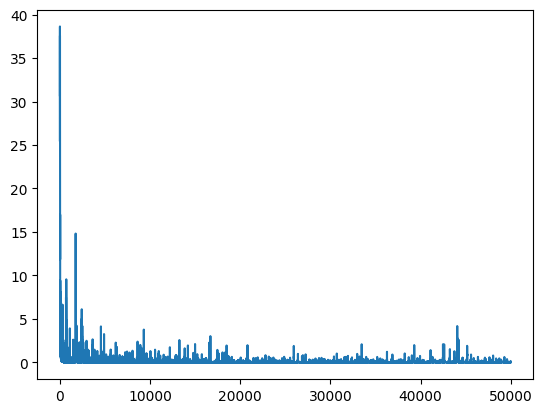

In [28]:
model.compile(optimizer = Adam(), metrics = ['loss'])

x = tf.linspace(-5, 5, 100)
history = model.fit(x, epochs = 50000, verbose = 0)
plt.plot(history.history['loss'])

4/4 [==============================] - 0s 2ms/step


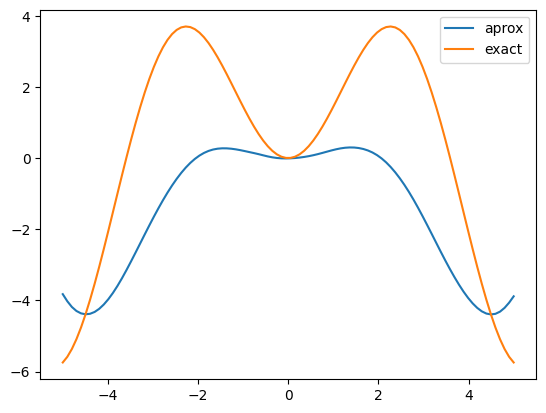

In [29]:
x_testv = tf.linspace(-5,5,100)
a=model.predict(x_testv)
plt.plot(x_testv,a,label="aprox")
plt.plot(x_testv, (x**2 * tf.math.sin(x) - 2. * x * tf.math.cos(x) + 2. * tf.math.sin(x)) / x,label="exact")
plt.legend()
plt.show()